### Import libraries

In [ ]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler, StandardScaler
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier


### Input & Output creation

In [82]:
# read file and create output file
input = 'C:/welead/project/project_root/data/curated_dataset.csv'

df = pd.read_csv(input)

In [83]:
# Separate features and target
X = df.drop(columns=['mpg', 'mpg_classes'])  # 'mpg_classes' is the column to predict
y = df['mpg_classes']

In [84]:
#first split the features from the target and then scale
# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=X.columns)

# Reversing the scaling if needed
# reversed_data = scaler.inverse_transform(scaled_data)

In [85]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [97]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1-Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=['Low', 'Med-Low', 'Med-High', 'High'],
                yticklabels=['Low', 'Med-Low', 'Med-High', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [87]:
def load_config(config_path='C:/welead/project/project_root/config.yaml'):
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

best_params = load_config()


### Ensemble models

In [90]:
print(best_params["feature_selection"])

['cylinders', 'displayments', 'horsepower', 'weight', 'acceleration', 'model year', 'origin_1', 'origin_2', 'origin_3']



Stacking Ensemble Model:
Accuracy: 0.9146341463414634
Precision (macro): 0.9252941176470588
Recall (macro): 0.9105882352941176
F1-Score (macro): 0.9128134384384384

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.94      0.80      0.86        20
           2       0.80      1.00      0.89        20
           3       1.00      0.88      0.94        17

    accuracy                           0.91        82
   macro avg       0.93      0.91      0.91        82
weighted avg       0.92      0.91      0.91        82



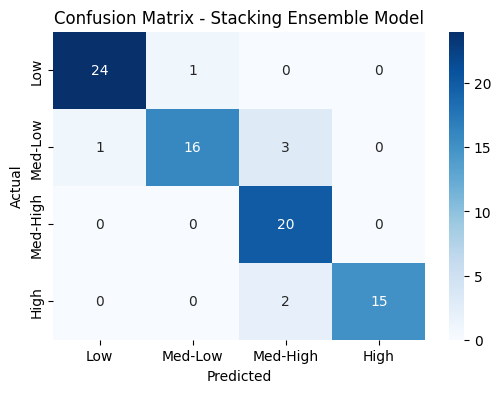

In [95]:
# Best performing models from each category
best_models = [
    ('random_forest', RandomForestClassifier(**best_params["random_forest_classifier"])),
    ('gradient_boosting', GradientBoostingClassifier(**best_params["gradient_boosting_classifier"])),
    ('knn',KNeighborsClassifier(**best_params["k_neighbors_classifier"]))
]

# Define the stacking ensemble model
stacking_model_top_3 = StackingClassifier(
    estimators=best_models,
    final_estimator=RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
)

# Create a pipeline with StandardScaler and the stacking model
pipeline_stacking_top_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("stacking", stacking_model_top_3)
])

# Train the stacking model
pipeline_stacking_top_3.fit(X_train, y_train)

# Evaluate the stacking model
stacking_pred_top_3 = pipeline_stacking_top_3.predict(X_test)
evaluate_model(y_test, stacking_pred_top_3, "Stacking Ensemble Model")